In [71]:
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
df_bench = pd.read_csv("stats/benchmark.csv", sep=';')
df_bench = df_bench.rename(columns={' Time': 'Time', ' Program': 'Program'})
df_bench

,Version,Time,Program
0,version_all_cuda,0:00:03.251804574,cu
1,version_baseline,0:00:30.087883472,cu
2,version_final,0:00:03.263911308,cu
3,version_lab_dist,0:00:09.895252171,cu
4,version_mean,0:00:03.978671945,cu
5,version_shrd_mem,0:00:07.819361286,cu
6,version_uchar3,0:00:03.218251997,cu
7,baseline,0:00:27.109233758,cpp


In [73]:
def get_seconds(time):
    str_rep = time.replace("0:00:", "")
    return float(str_rep)

In [74]:
df_bench['Time'] = df_bench['Time'].apply(get_seconds)
df_bench = df_bench.sort_values(by='Time', ascending=False)
df_bench

,Version,Time,Program
1,version_baseline,30.087883,cu
7,baseline,27.109234,cpp
3,version_lab_dist,9.895252,cu
5,version_shrd_mem,7.819361,cu
4,version_mean,3.978672,cu
2,version_final,3.263911,cu
0,version_all_cuda,3.251805,cu
6,version_uchar3,3.218252,cu


In [75]:
df = df_bench
df_principal = df_bench

# Create a color map based on the 'Program' column
colors = {'cu': 'blue', 'cpp': 'green'}
df['Color'] = df['Program'].map(colors)
df_principal['Color'] = df_principal['Program'].map(colors)
df_principal = df_principal[(df_principal["Version"] == "version_final") | (df_principal["Version"] == 'baseline') | (df_principal["Version"] == 'version_lab_dist')]

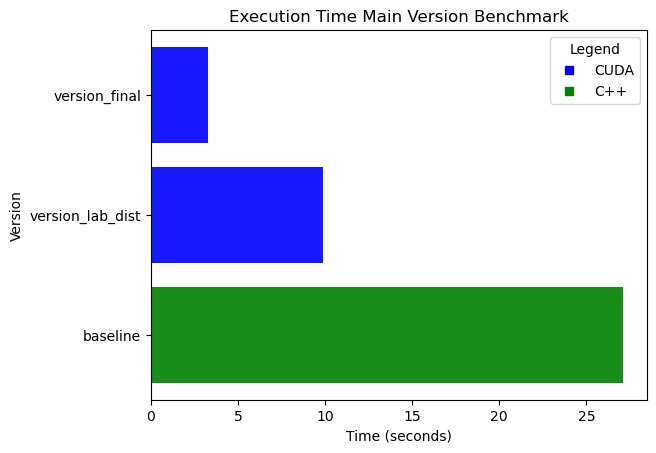

In [76]:
# Plot the horizontal bar graph
plt.barh(df_principal['Version'], df_principal['Time'], color=df_principal['Color'], alpha=0.9)

# Customize the plot
plt.xlabel('Time (seconds)')
plt.ylabel('Version')
plt.title('Execution Time Main Version Benchmark')

dummy_lines = [plt.Line2D([0], [0], marker='s', color='blue', lw=0, label='CUDA'),
               plt.Line2D([0], [0], marker='s', color='green', lw=0, label='C++')]
plt.legend(handles=dummy_lines, title='Legend', loc='upper right')


plt.show()

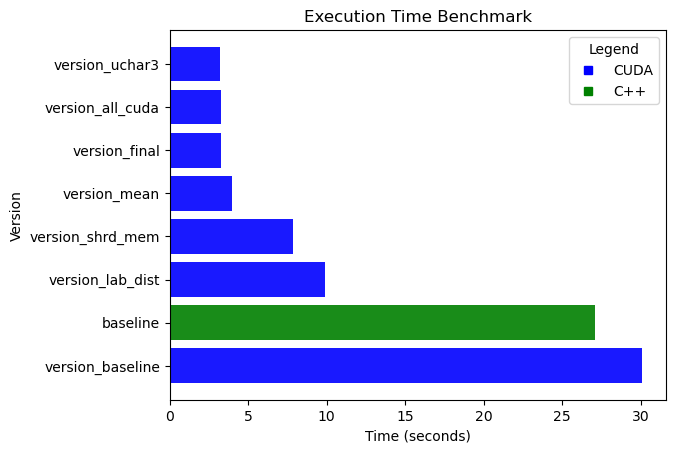

In [77]:
# Plot the horizontal bar graph
plt.barh(df['Version'], df['Time'], color=df['Color'], alpha=0.9)

# Customize the plot
plt.xlabel('Time (seconds)')
plt.ylabel('Version')
plt.title('Execution Time Benchmark')

dummy_lines = [plt.Line2D([0], [0], marker='s', color='blue', lw=0, label='CUDA'),
               plt.Line2D([0], [0], marker='s', color='green', lw=0, label='C++')]
plt.legend(handles=dummy_lines, title='Legend', loc='upper right')


plt.show()

In [78]:
def nvprof_time(nvprof_file, viz=False):
    df = pd.read_csv(nvprof_file, skiprows=3)
    df = df.drop(index=0)
    df = df.reset_index(drop=True)

    df["Time(%)"] = df["Time(%)"].astype(float)
    df["Time"] = df["Time"].astype(float)

    df_gpu = df[(df["Type"] == "GPU activities") & (df["Time(%)"] > 1)]
    df_api = df[(df["Type"] == "API calls") & (df["Time(%)"] > 1)]

    if viz:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        axes[0].pie(df_gpu['Time(%)'], labels=df_gpu['Name'], autopct='%1.1f%%')
        axes[0].set_title('GPU activities')
        axes[1].pie(df_api['Time(%)'], labels=df_api['Name'], autopct='%1.1f%%')
        axes[1].set_title('API calls')

        plt.tight_layout()
        plt.show()

    return df


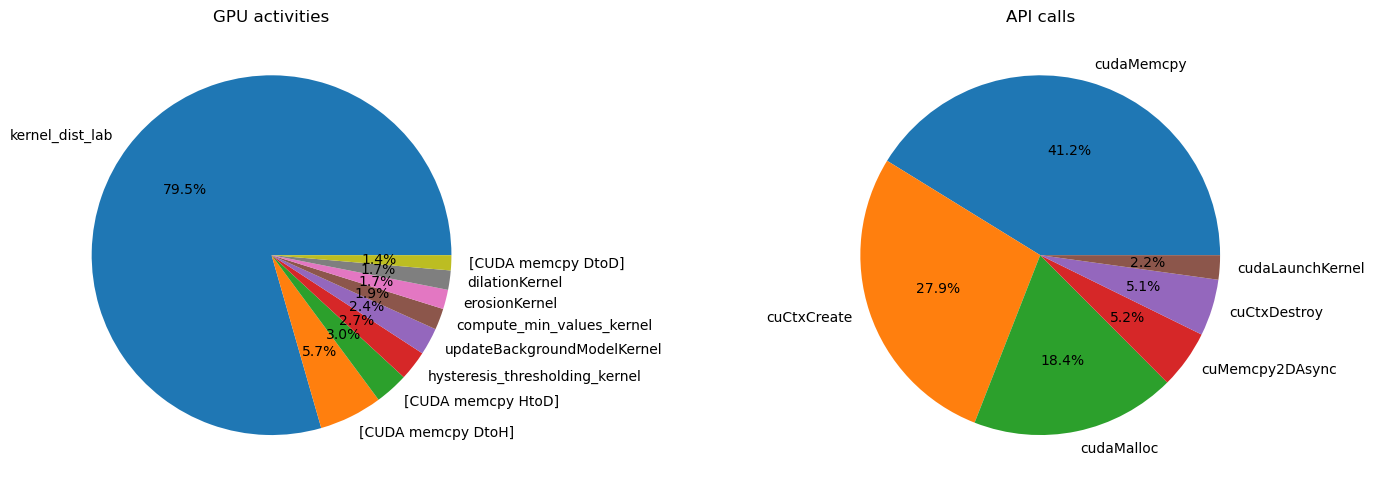

In [79]:
df_final = nvprof_time("stats/log_version_final.csv", viz=True)
df_all_cuda = nvprof_time("stats/log_version_all_cuda.csv")
df_baseline_cu = nvprof_time("stats/log_version_baseline.csv")
df_simple_cuda = nvprof_time("stats/log_version_lab_dist.csv") # Lab dist
df_shrd_mem = nvprof_time("stats/log_version_shrd_mem.csv")
df_mean = nvprof_time("stats/log_version_mean.csv")
df_uchar = nvprof_time("stats/log_version_uchar3.csv", viz=False)

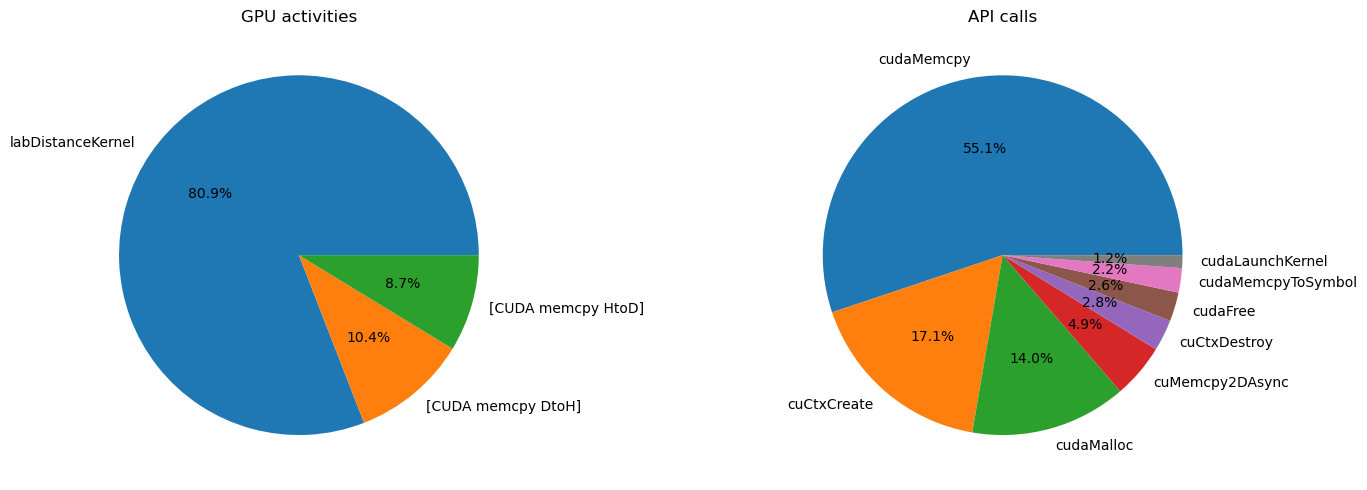

In [80]:
nvprof_time("stats/log_version_lab_dist.csv", viz=True)
None

In [81]:
versions = ["baseline", "simple_cuda", "shared-mem", "background_mean", "all_cuda", "to_uchar3", "final"]
df_list = [df_baseline_cu, df_simple_cuda, df_shrd_mem, df_mean, df_all_cuda, df_uchar, df_final]

def plot_criteria_evolution(df_list, name, col, name2=None):
    evolution = []
    for df in df_list:
        if (len(df[df["Name"] == name][col]) == 0):
            if name2:
                if (len(df[df["Name"] == name2][col]) == 0):
                    evolution.append(0)
                else:
                    evolution.append(float(df[df["Name"] == name2][col].iloc[0]))
            else:
                evolution.append(0)
        else:
            evolution.append(float(df[df["Name"] == name][col].iloc[0]))

    # Plotting
    plt.figure(figsize=(10, 8))
    # plt.bar(versions, evolution, color='blue')
    plt.plot(versions, evolution, marker='o', linestyle='--')
    plt.xlabel('Versions')
    plt.ylabel(col)
    plt.title(f'Evolution of {name} {col} through versions')
    plt.show()

### L'activite GPU

In [82]:
df_final[df_final["Type"] == 'GPU activities']["Name"]

0                    kernel_dist_lab
1                 [CUDA memcpy DtoH]
2                 [CUDA memcpy HtoD]
3     hysteresis_thresholding_kernel
4        updateBackgroundModelKernel
5          compute_min_values_kernel
6                      erosionKernel
7                     dilationKernel
8                 [CUDA memcpy DtoD]
9       apply_color_to_buffer_kernel
10               ConvertNV12BLtoNV12
11                     [CUDA memset]
12                      MemsetD2D_BL
Name: Name, dtype: object

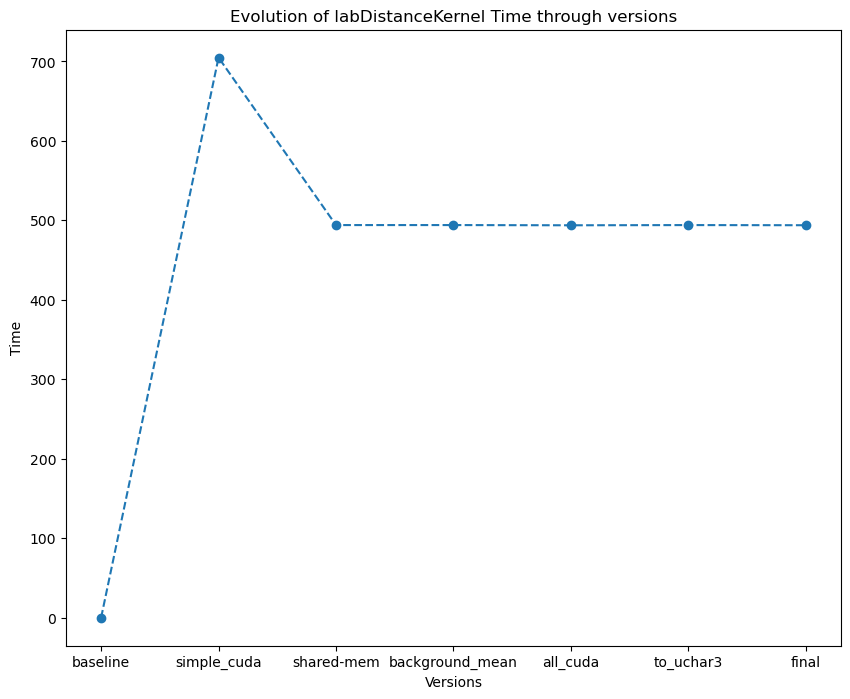

In [83]:
plot_criteria_evolution(df_list, 'labDistanceKernel', 'Time', 'kernel_dist_lab')

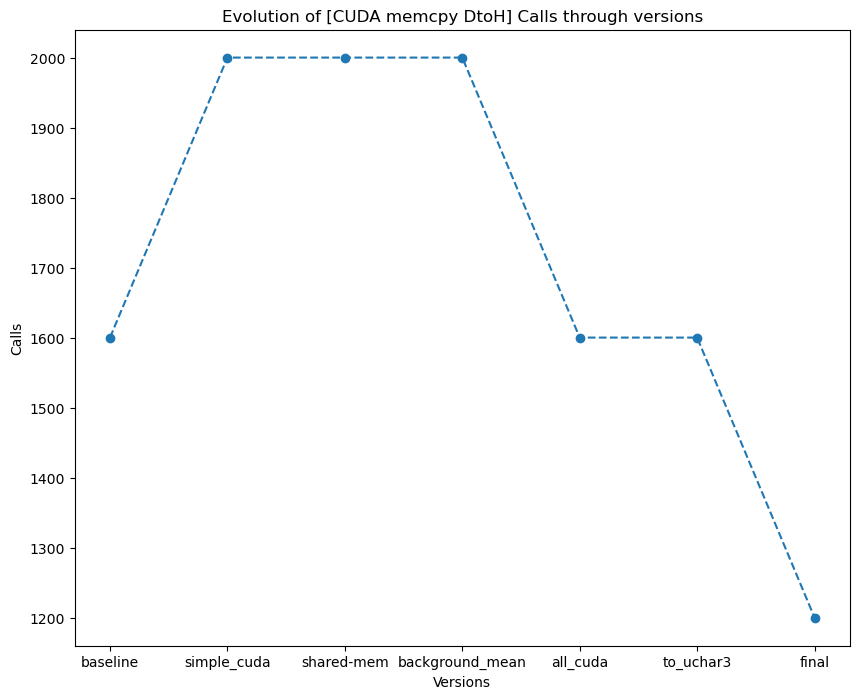

In [84]:
plot_criteria_evolution(df_list, '[CUDA memcpy DtoH]', 'Calls')

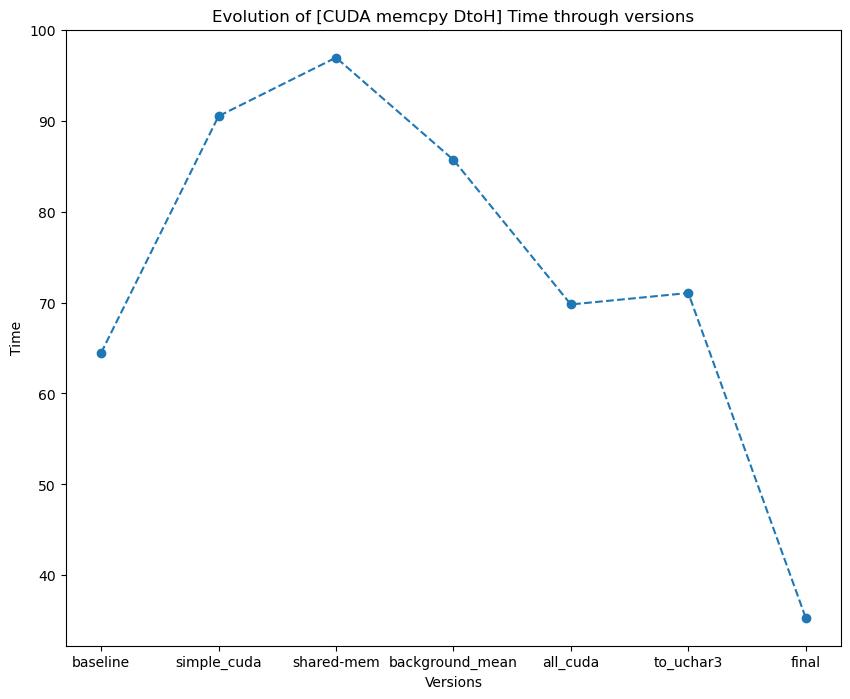

In [85]:
plot_criteria_evolution(df_list, '[CUDA memcpy DtoH]', 'Time')

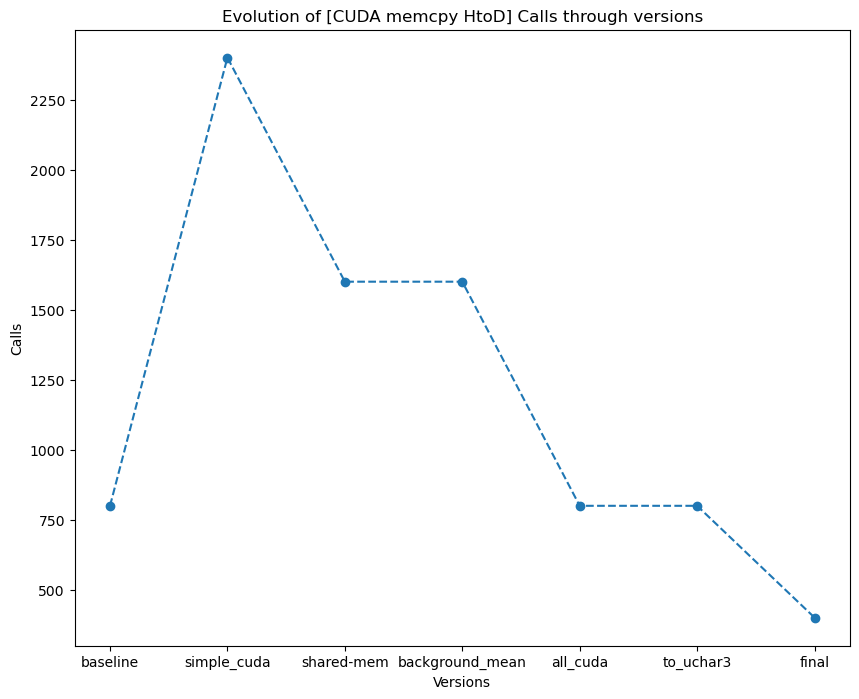

In [86]:
plot_criteria_evolution(df_list, '[CUDA memcpy HtoD]', 'Calls')

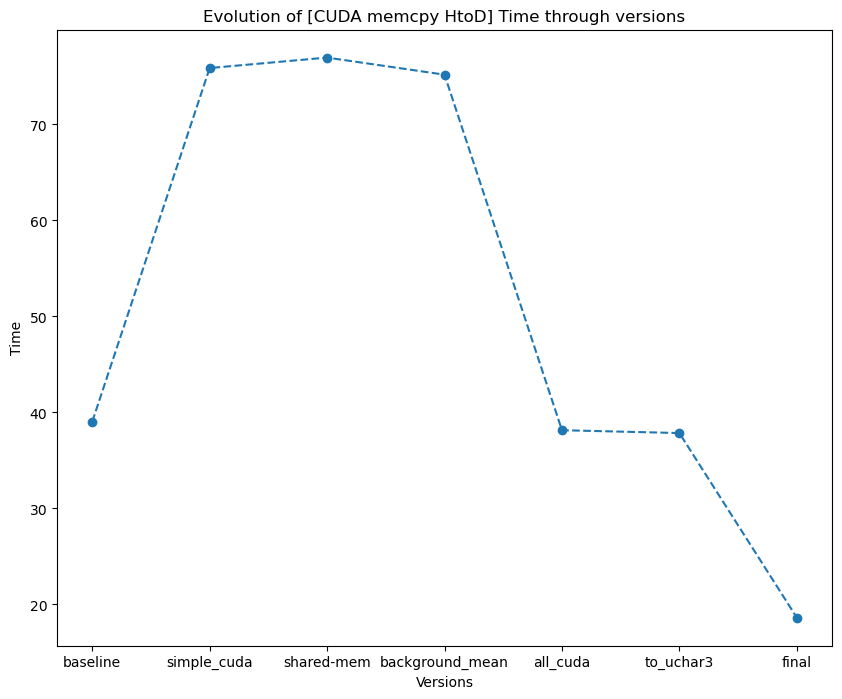

In [87]:
plot_criteria_evolution(df_list, '[CUDA memcpy HtoD]', 'Time')

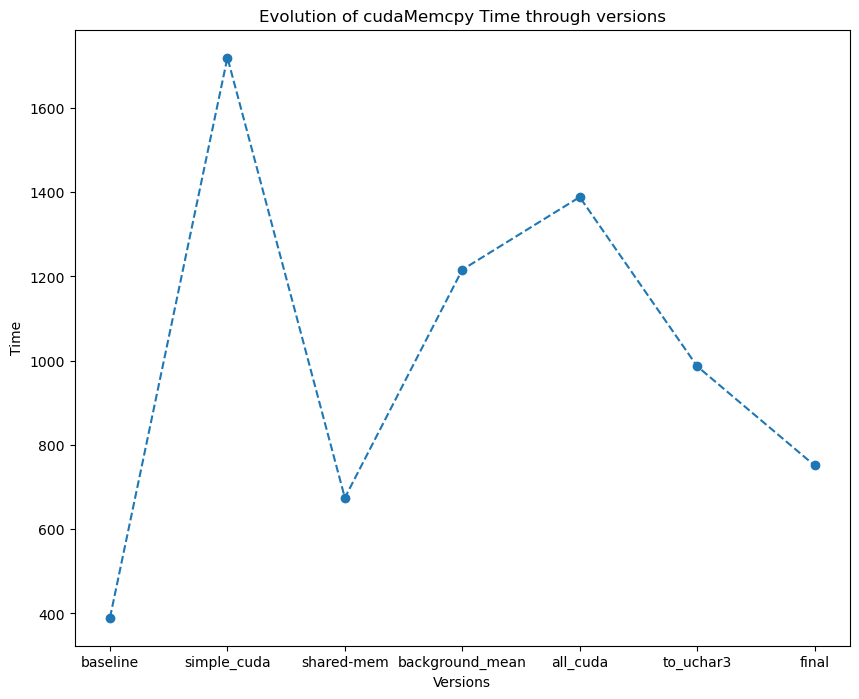

In [88]:
plot_criteria_evolution(df_list, 'cudaMemcpy', 'Time')

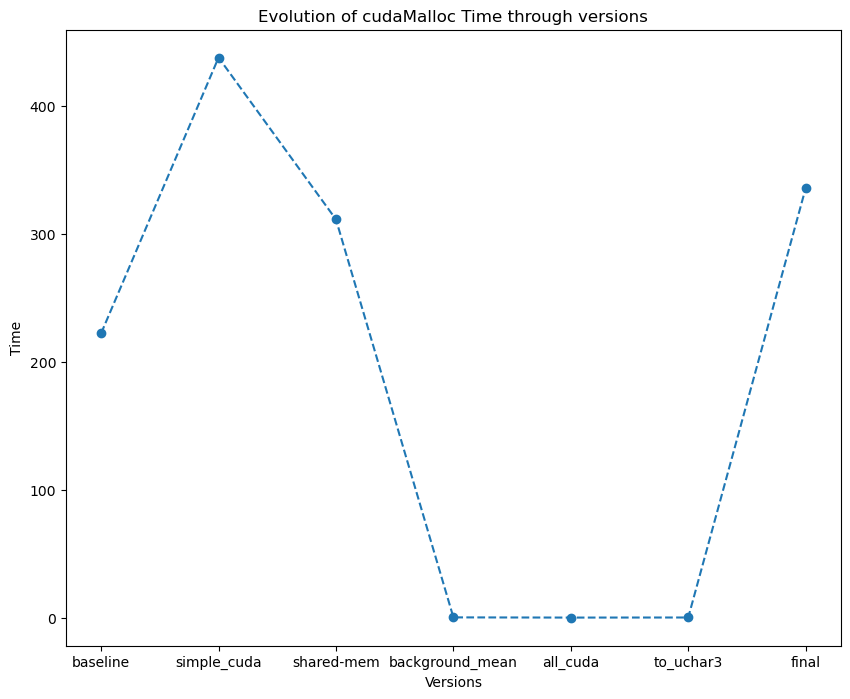

In [89]:
plot_criteria_evolution(df_list, 'cudaMalloc', 'Time')

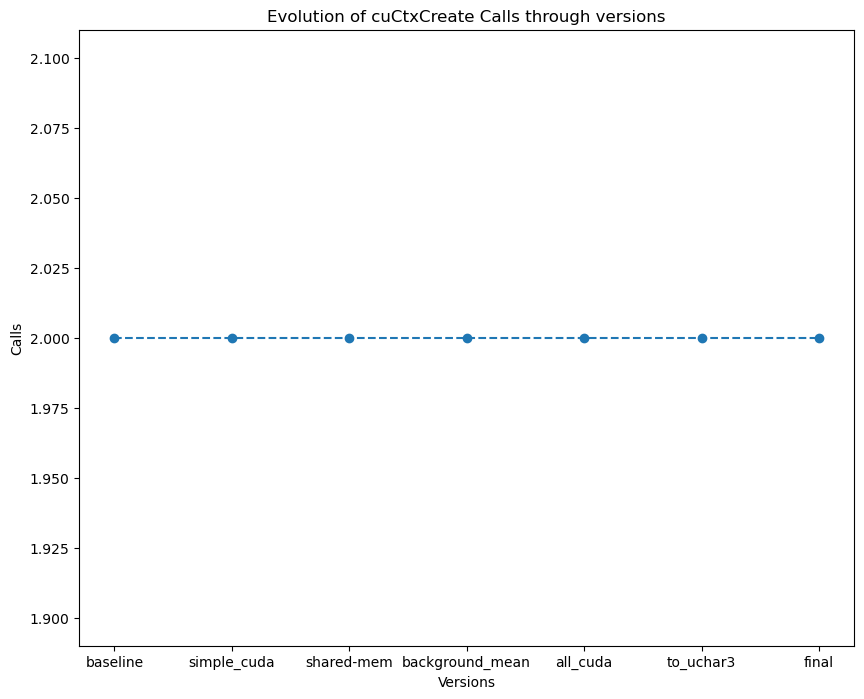

In [90]:
plot_criteria_evolution(df_list, 'cuCtxCreate', 'Calls')

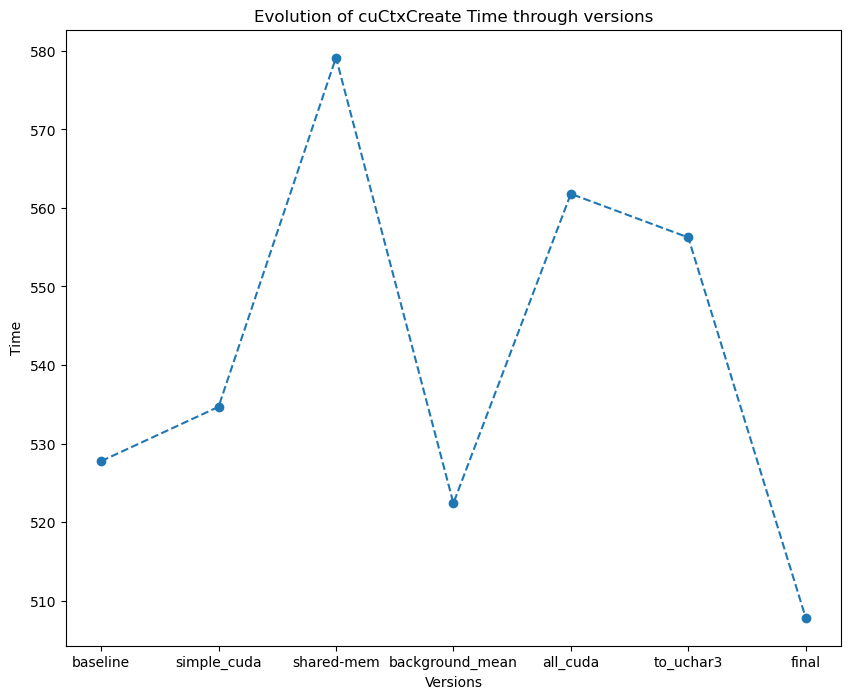

In [91]:
plot_criteria_evolution(df_list, 'cuCtxCreate', 'Time')

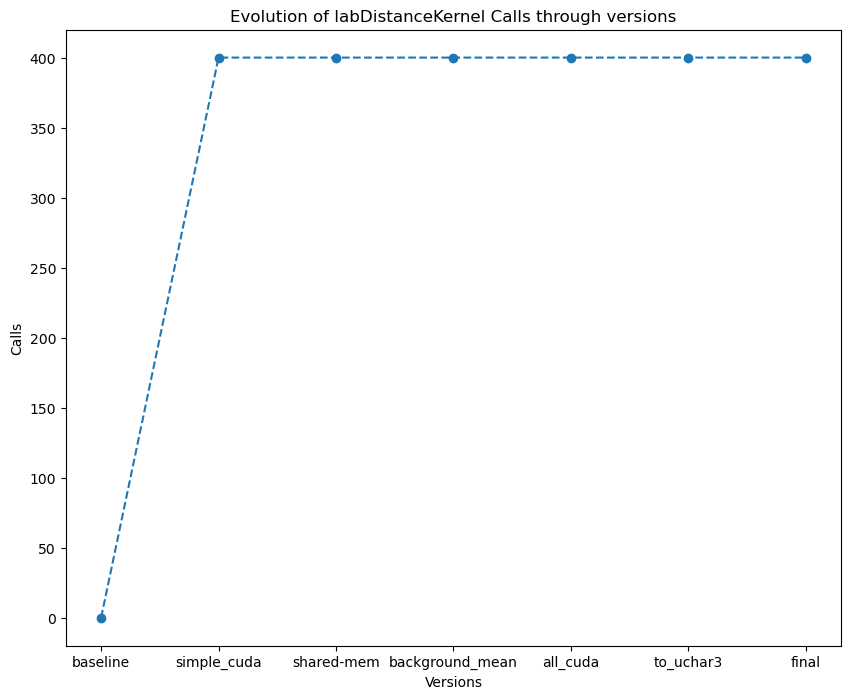

In [92]:
plot_criteria_evolution(df_list, 'labDistanceKernel', 'Calls', 'kernel_dist_lab')